[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

# Supervised variant prediction with ESM

**Note, this example notebook predates our work on zero-shot variant prediction, which is presented in `examples/variant-prediction`**.

This tutorial demonstrates how to train a simple variant predictor, i.e. we predict the biological activity of mutations of a protein, using fixed embeddings from ESM. You can adopt a similar protocol to train a model for any downstream task, even with limited data.

We will use a simple classifier in sklearn (or "head" on top of the transformer features) to predict the mutation effect from precomputed ESM embeddings. The embeddings for your dataset can be dumped once using a GPU. Then, the rest of your analysis can be done on CPU. 

### Background

In this particular example, we will train a model to predict the activity of ß-lactamase variants.

We provide the training in `examples/data/P62593.fasta`, a FASTA file where each entry contains:
- the mutated ß-lactamase sequence, where a single residue is mutated (swapped with another amino acid)
- the target value in the last field of the header, describing the scaled effect of the mutation

The [data originally comes](https://github.com/FowlerLab/Envision2017/blob/master/data/dmsTraining_2017-02-20.csv) from a deep mutational scan and was released with the Envision paper (Gray, et al. 2018)

### Goals
- Obtain an embedding (fixed-dimensional vector representation) for each mutated sequence.
- Train a regression model in sklearn that can predict the "effect" score given the embedding.


### Prerequisites
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- You have obtained sequence embeddings for ß-lactamase as described in the README:
```
python scripts/extract.py esm1v_t33_650M_UR90S_1 examples/data/P62593.fasta examples/data/P62593_emb_esm1v/ --repr_layers 33 --include mean
```


### Table of Contents
1. [Prelims](#prelims)
1. [Loading Embeddings](#load_embeddings)
1. [Visualizing Embeddings](#viz_embeddings)
1. [Initializing / Running Grid Search](#grid_search)
1. [Browse Grid Search Results](#browse)
1. [Evaluating Results](#eval)

<a id='prelims'></a>
## Prelims

If you are using colab, then uncomment and run the cell below.
It will pip install the `esm` code, fetch the fasta file and the pre-computed embeddings.

In [1]:
# !pip install git+https://github.com/facebookresearch/esm.git
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
# !tar -xzf P62593_reprs.tar.gz
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
# !pwd
# !ls

In [1]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

/stor/home/amh7958/miniconda3/envs/efficient-evolution/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

## Add the path to your embeddings here:


In [18]:
FASTA_PATH = "../data/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "../output/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

<a id='load_embeddings'></a>
## Load embeddings (Xs) and target effects (ys)
Our FASTA file is formatted as such:
```
>{index}|{mutation_id}|{effect}
{seq}
```
We will be extracting the effect from each entry.

Our embeddings are stored with the file name from fasta header: `{index}|{mutation_id}|{effect}.pt`

In [19]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

5397
(5397, 1280)


### Train / Test Split

Here we choose to follow the Envision paper, using 80% of the data for training, but we actually found that pre-trained ESM embeddings require fewer downstream training examples to reach the same level of performance.

In [20]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [21]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((4317, 1280), (1080, 1280), 4317, 1080)

### PCA

Principal Component Analysis is a popular technique for dimensionality reduction. Given `n_features` (1280 in our case), PCA computes a new set of `X` that "best explain the data." We've found that this enables downstream models to be trained faster with minimal loss in performance.  

Here, we set `X` to 60, but feel free to change it!


In [22]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

<a id='viz_embeddings'></a>
## Visualize Embeddings

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

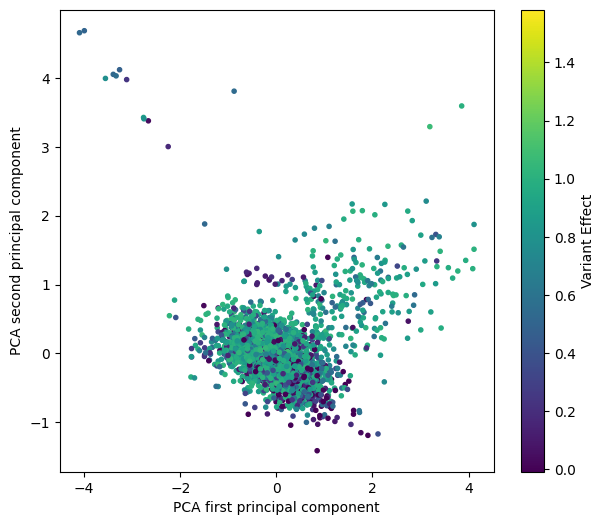

In [23]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')

<a id='grid_search'></a>

## Initialize / Run GridSearch

We will run grid search for three different regression models:
1. [K-nearest-neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
2. [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)
3. [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor)

Here, we will be using the PCA-projected features because we observe it does just as well as `Xs` while allowing for faster training. You can easily swap it out for `Xs`.

### Initialize grids for different regression techniques

In [ ]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

In [ ]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

### Run Grid Search 

(will take a few minutes on a single core)

In [14]:
# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits
<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


<a id='browse'></a>
## Browse the Sweep Results

The following tables show the top 5 parameter settings, based on `mean_test_score`. Given our setup, this should really be thought of as `validation_score`.

### K Nearest Neighbors

In [15]:
result_list[0].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.861867,0.283238,0.816056,0.063010,"KNeighborsRegressor(algorithm='ball_tree', p=1...",ball_tree,30,5,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.695010,0.705608,0.657999,0.644695,0.665164,0.673695,0.022947,1
1,1.765102,0.207029,0.689800,0.216780,"KNeighborsRegressor(algorithm='ball_tree', p=1...",ball_tree,15,5,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.690265,0.701557,0.661057,0.649508,0.665427,0.673563,0.019307,2
17,0.589193,0.099892,1.422166,0.152255,"KNeighborsRegressor(algorithm='ball_tree', p=1...",kd_tree,15,5,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.693205,0.700961,0.663998,0.648063,0.659884,0.673222,0.020321,3
33,1.284200,0.496219,1.202915,0.300557,"KNeighborsRegressor(algorithm='ball_tree', p=1...",brute,15,5,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.692801,0.698600,0.661247,0.649249,0.660964,0.672572,0.019461,4
41,1.363155,0.416416,0.370380,0.174864,"KNeighborsRegressor(algorithm='ball_tree', p=1...",brute,30,5,1,distance,{'model': KNeighborsRegressor(algorithm='ball_...,0.695918,0.701295,0.655434,0.641803,0.661102,0.671110,0.023372,5


### SVM

In [16]:
result_list[1].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__degree,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.596057,0.374811,0.187232,0.012077,SVR(),1.0,3,scale,rbf,"{'model': SVR(), 'model__C': 1.0, 'model__degr...",0.737071,0.726406,0.678442,0.702208,0.689338,0.706693,0.022049,1
10,2.030772,0.278808,0.183248,0.008195,SVR(),10.0,3,scale,rbf,"{'model': SVR(), 'model__C': 10.0, 'model__deg...",0.701482,0.713377,0.671624,0.691004,0.681054,0.691708,0.014714,2
2,1.559752,0.208916,0.218885,0.045596,SVR(),0.1,3,scale,rbf,"{'model': SVR(), 'model__C': 0.1, 'model__degr...",0.643568,0.621554,0.574986,0.610664,0.578071,0.605769,0.026141,3
5,2.062963,0.209779,0.078716,0.004191,SVR(),1.0,3,scale,poly,"{'model': SVR(), 'model__C': 1.0, 'model__degr...",0.523832,0.425124,0.448338,0.476281,0.418398,0.458395,0.038496,4
8,1.457202,0.369496,0.079903,0.004191,SVR(),10.0,3,scale,linear,"{'model': SVR(), 'model__C': 10.0, 'model__deg...",0.484858,0.446688,0.434547,0.442608,0.432603,0.448261,0.019011,5


### Random Forest

In [17]:
result_list[2].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__criterion,param_model__max_features,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.185552,0.132015,0.015165,0.000395,"RandomForestRegressor(max_features='log2', min...",squared_error,log2,1,5,20,{'model': RandomForestRegressor(max_features='...,0.533933,0.530109,0.503419,0.519353,0.467033,0.510769,0.024295,1
1,1.334341,0.110625,0.012710,0.001579,"RandomForestRegressor(max_features='log2', min...",squared_error,sqrt,1,10,20,{'model': RandomForestRegressor(max_features='...,0.539230,0.510809,0.481912,0.528806,0.479765,0.508105,0.024058,2
0,1.445742,0.118084,0.013353,0.001643,"RandomForestRegressor(max_features='log2', min...",squared_error,sqrt,1,5,20,{'model': RandomForestRegressor(max_features='...,0.530501,0.514021,0.491199,0.516743,0.487662,0.508025,0.016217,3
2,1.495729,0.124626,0.010826,0.000706,"RandomForestRegressor(max_features='log2', min...",squared_error,sqrt,4,5,20,{'model': RandomForestRegressor(max_features='...,0.514546,0.533379,0.479104,0.518605,0.459918,0.501110,0.027236,4
8,12.151597,1.092783,0.010862,0.001263,"RandomForestRegressor(max_features='log2', min...",absolute_error,sqrt,1,5,20,{'model': RandomForestRegressor(max_features='...,0.505719,0.502644,0.470106,0.511916,0.468395,0.491756,0.018625,5


<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [18]:
for grid in grid_list:
    print(grid.best_estimator_.get_params()["steps"][1][1]) # get the model details from the estimator
    print()
    preds = grid.predict(Xs_test)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')


KNeighborsRegressor(algorithm='ball_tree', p=1, weights='distance')

SpearmanrResult(correlation=0.8065398315270731, pvalue=2.4681127050485095e-248)

 -------------------------------------------------------------------------------- 

SVR()

SpearmanrResult(correlation=0.8147793655720186, pvalue=1.8403540985305893e-257)

 -------------------------------------------------------------------------------- 

RandomForestRegressor(max_features='log2', min_samples_split=5, n_estimators=20)

SpearmanrResult(correlation=0.7277072328713822, pvalue=1.0094601306397444e-178)

 -------------------------------------------------------------------------------- 



The SVM performs the best on the `test` set, with a spearman rho of 0.815! 

This is in line with our grid-search results, where it also had the best `validation` performance.

In conclusion, our downstream model was able to use fixed pre-trained ESM embedding representations and obtain a decent result.

For reference, we report correlation of 0.89 in Table 7 of [Rives et al.](https://www.biorxiv.org/content/10.1101/622803v3), but this was achieved by fine-tuning the model, and with ESM-1, before we developed ESM-1v.

**For zero-shot variant prediction, see `examples/variant-prediction`**